# Lesson 1 - What's your pet

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [13]:
SCRATCH = os.path.expandvars('$SCRATCH')
DATA_PATH = SCRATCH+"/fastai_data/"

In [2]:
# import fastai
from fastai.vision import *
from fastai.metrics import error_rate

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller *batch size* (you'll learn all about what this means during the course), and try again.

Batch size is only concerned with how fast you train your model. So, it’s ok to make it smaller

In [3]:
# batch size 
bs = 64
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

## Looking at the data

We are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. Our model will need to learn to differentiate between these 37 distinct categories. According to their paper, the best accuracy they could get in 2012 was 59.21%, using a complex model that was specific to pet detection, with separate "Image", "Head", and "Body" models for the pet photos. Let's see how accurate we can be using deep learning!

We are going to use the `untar_data` function to which we must pass a URL as an argument and which will download and extract the data.

I've already change the default data path to Scratch.

In [40]:
# This create a concrete path object, check Python API
path = untar_data(URLs.PETS); path

PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet')

In [16]:
path.ls()

[PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet/annotations'),
 PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet/images')]

In [17]:
# This use path object in Python3
path_anno = path/'annotations'
path_img = path/'images'

The first thing we do when we approach a problem is to take a look at the data. We _always_ need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

The main difference between the handling of image classification datasets is the way labels are stored. In this particular dataset, labels are stored in the filenames themselves. We will need to extract them to be able to classify the images into the correct categories. Fortunately, the fastai library has a handy function made exactly for this, `ImageDataBunch.from_name_re` gets the labels from the filenames using a [regular expression](https://docs.python.org/3.6/library/re.html).

In [18]:
# The path_img here is a path object
fnames = get_image_files(path_img)
# Return a list of PosixPath objects
fnames[:5]

[PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet/images/Maine_Coon_247.jpg'),
 PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet/images/wheaten_terrier_166.jpg'),
 PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet/images/Egyptian_Mau_209.jpg'),
 PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet/images/Ragdoll_188.jpg'),
 PosixPath('/scratch/zl2501/fastai_data/data/oxford-iiit-pet/images/havanese_120.jpg')]

## Regular Expression

`r'/([^/]+)_\d+.jpg$'` indicates a raw string notation, which is used to do regular expression. 

```
$	 Match the end of the targeted string
.jpg last chars to be found in the search string, also right file format checking
\d	 numerical digits, ‘+’ sign denotes can be one or more of them
_	 matches should come before the start of digits
()	 denotes a group of characters
[]	 denotes a character set or a character class. 
^/	 ‘^’ , a caret after the opening square bracket negates the character class. This means characters except '/'
( [ ^/ ] + )	The '+' means repeat a least one time. This indicates searches all characters except ‘/’
/	 match a character '/'
```

In [19]:
# Set random seed
np.random.seed(2)
# Create a pattern of regular expression to be used to extract the label from the file name
pat = re.compile(r'/([^/]+)_\d+.jpg$')

In fastai, the object called **ImageDataBunch** represents all of the data you need to build model -- **a training set, a validation set with images and labels**.
After create the ImageDataBunch, we need to normalize it.

In [43]:
# Create the ImageDataBunch and normalize the data!
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224, bs=bs
                                  ).normalize(imagenet_stats)
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

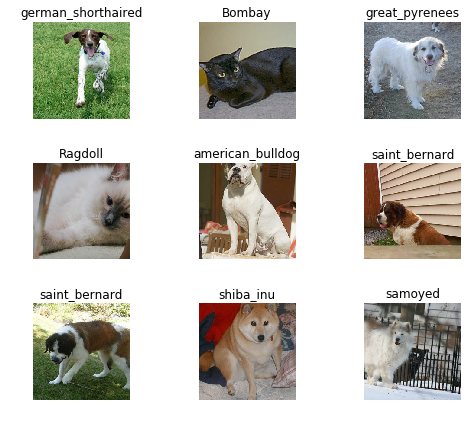

In [41]:
data.show_batch(rows=3, figsize=(7,6))

In [22]:
# The ImageDataBunch has an attributes, classes
print(data.classes)
# 
len(data.classes),data.c

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


(37, 37)

## Transfer Training: resnet34

Now we will start training our model. We will use a [convolutional neural network](http://cs231n.github.io/convolutional-networks/) backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Not to worry, we will dive deeper in the coming lessons. For the moment you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories (in this case, it will have 37 outputs).

We will train for 4 epochs (4 cycles through all our data).

Here the laerner is a general concept for things that can learn to fit a model.

In [23]:
# The minimal parameters to create a CNN classifier: data, pre-trained model, metrics. 
# Meterics are the things you want to be printed out
learn = create_cnn(data, models.resnet34, metrics=error_rate)

In [24]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [25]:
# Run 4 epoches
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate
1,1.408643,0.324250,0.097429
2,0.565746,0.238435,0.079838
3,0.350326,0.204593,0.063599
4,0.264398,0.197158,0.062246


In [26]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

## Loss function

A loss function is something that tells you how good was your predicition. It's actually the MSE(Mean Square Error) function on validation set. The small, the better.

By plotting the top losses, we are going to find out what were the things that we were the most wrong on, or the most foncident about what we got wrong.

In [27]:
# Use this factory method to create the output object, interp.
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

The title indicates the following things: prediction, actual labels, loss, probability to be the actual class

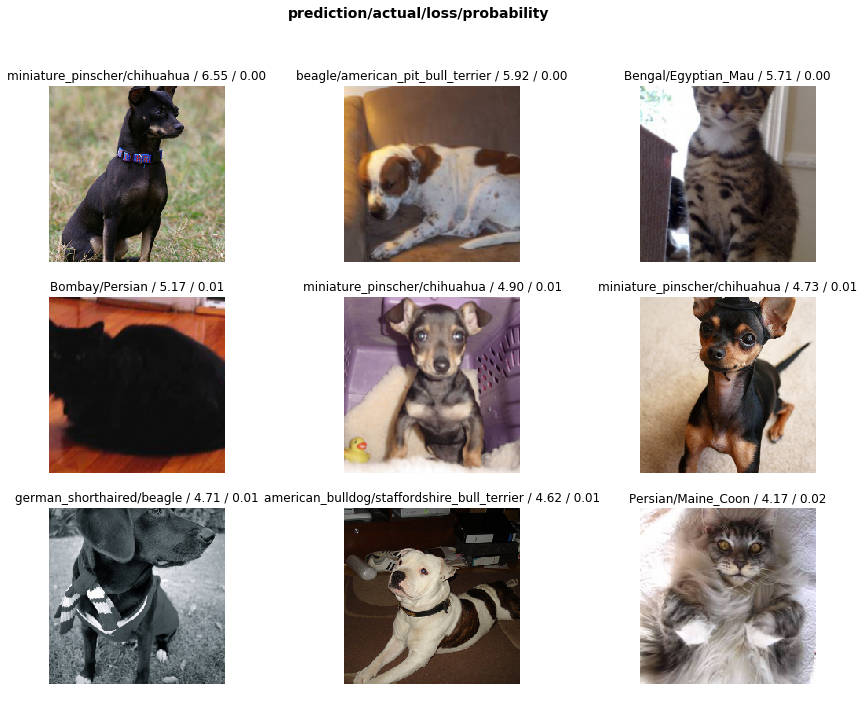

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

## Confusion Matrix

In [29]:
doc(interp.plot_top_losses)

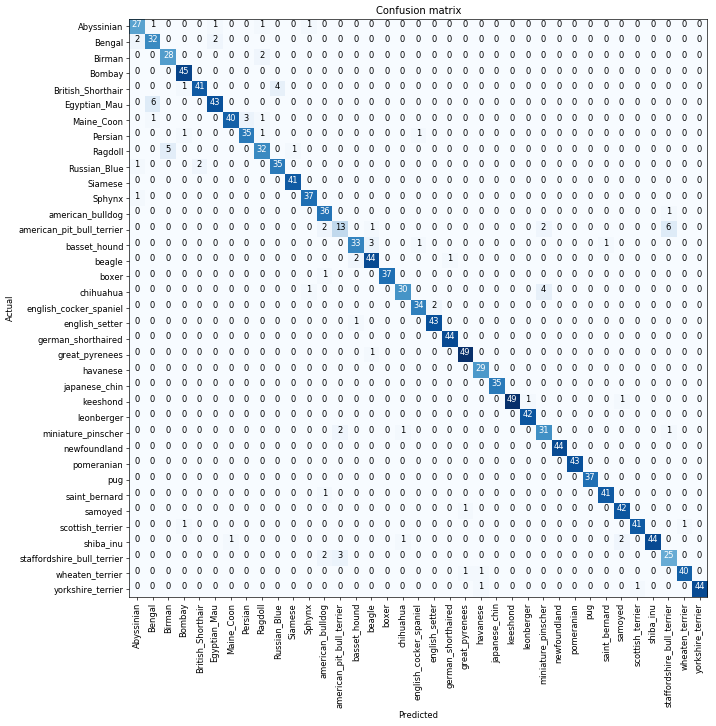

In [30]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [31]:
interp.most_confused(min_val=2)

[('Egyptian_Mau', 'Bengal', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('Maine_Coon', 'Persian', 3),
 ('basset_hound', 'beagle', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3)]

## Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will *unfreeze* our model and train some more.

In [32]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate
1,0.558230,0.320203,0.101489


After training once, our model gets worse. The reason is that we change too much on the front hidden layers. By default, the training rate on all layers is 0.003.

In [35]:
# Get back to the formal status
learn.load('stage-1');

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


We need to find the optimal learning rate for our model. Here, before the loss gets worse, the number is around 1e-4

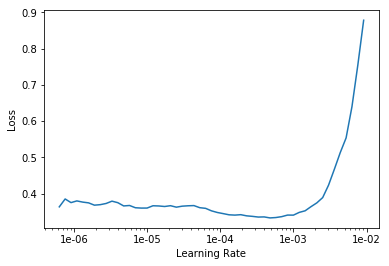

In [36]:
learn.recorder.plot()

A slice object is used to specify how to slice a sequence. You can specify where to start the slicing, and where to end. You can also specify the step, which allows you to e.g. slice only every other item.

The slice function can take a start value and a stop value and basically what this says is train the very first layers at a learning rate of 1e-6, and the very last layers at a rate of 1e-4, and distribute all the other layers across that between those two values equally.

In [37]:
learn.unfreeze()
# This time we give different learning rate.
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.230585,0.188827,0.062246
2,0.208420,0.183647,0.058187


That's a pretty accurate model!

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. It will be explained later in the course and you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here. To help it along, let's us use larger images too, since that way the network can see more detail. We reduce the batch size a bit since otherwise this larger network will require more GPU memory.

In [ ]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(),
                                   size=299, bs=bs//2).normalize(imagenet_stats)

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


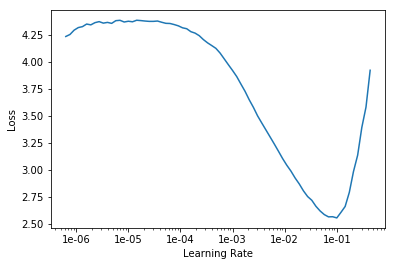

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8)

Total time: 06:59
epoch  train_loss  valid_loss  error_rate
1      0.548006    0.268912    0.076455    (00:57)
2      0.365533    0.193667    0.064953    (00:51)
3      0.336032    0.211020    0.073072    (00:51)
4      0.263173    0.212025    0.060893    (00:51)
5      0.217016    0.183195    0.063599    (00:51)
6      0.161002    0.167274    0.048038    (00:51)
7      0.086668    0.143490    0.044655    (00:51)
8      0.082288    0.154927    0.046008    (00:51)



In [ ]:
learn.save('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6,1e-4))

Total time: 03:27
epoch  train_loss  valid_loss  error_rate
1      0.097319    0.155017    0.048038    (01:10)
2      0.074885    0.144853    0.044655    (01:08)
3      0.063509    0.144917    0.043978    (01:08)



If it doesn't, you can always go back to your previous model.

In [ ]:
learn.load('stage-1-50');

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.most_confused(min_val=2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Bengal', 'Egyptian_Mau', 5),
 ('Bengal', 'Abyssinian', 4),
 ('boxer', 'american_bulldog', 4),
 ('Ragdoll', 'Birman', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

## Other data formats

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE); path

PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample')

In [ ]:
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=26)

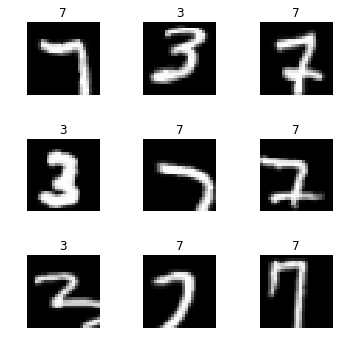

In [ ]:
data.show_batch(rows=3, figsize=(5,5))

In [ ]:
learn = create_cnn(data, models.resnet18, metrics=accuracy)
learn.fit(2)

Total time: 00:23
epoch  train_loss  valid_loss  accuracy
1      0.116117    0.029745    0.991168  (00:12)
2      0.056860    0.015974    0.994603  (00:10)



In [ ]:
df = pd.read_csv(path/'labels.csv')
df.head()

,name,label
0,train/3/7463.png,0
1,train/3/21102.png,0
2,train/3/31559.png,0
3,train/3/46882.png,0
4,train/3/26209.png,0


In [ ]:
data = ImageDataBunch.from_csv(path, ds_tfms=tfms, size=28)

[0, 1]

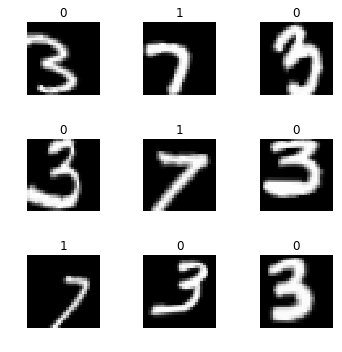

In [ ]:
data.show_batch(rows=3, figsize=(5,5))
data.classes

In [ ]:
data = ImageDataBunch.from_df(path, df, ds_tfms=tfms, size=24)
data.classes

[0, 1]

In [ ]:
fn_paths = [path/name for name in df['name']]; fn_paths[:2]

[PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/7463.png'),
 PosixPath('/home/ubuntu/course-v3/nbs/dl1/data/mnist_sample/train/3/21102.png')]

In [ ]:
pat = r"/(\d)/\d+\.png$"
data = ImageDataBunch.from_name_re(path, fn_paths, pat=pat, ds_tfms=tfms, size=24)
data.classes

['3', '7']

In [ ]:
data = ImageDataBunch.from_name_func(path, fn_paths, ds_tfms=tfms, size=24,
        label_func = lambda x: '3' if '/3/' in str(x) else '7')
data.classes

['3', '7']

In [ ]:
labels = [('3' if '/3/' in str(x) else '7') for x in fn_paths]
labels[:5]

['3', '3', '3', '3', '3']

In [ ]:
data = ImageDataBunch.from_lists(path, fn_paths, labels=labels, ds_tfms=tfms, size=24)
data.classes

['3', '7']